In [1]:
import random
import pandas as pd
import requests
from sklearn.cluster import KMeans

# Randomly generate a gps location for our vehicle.
def getGPS():
    lat = random.uniform(29.4, 30.0)
    lon = random.uniform(-95.6, -94.9)
    return lat, lon
car_lat, car_lon = getGPS()

print(f"Generated new car at: ({car_lat}, {car_lon})")

# Fuel always under 10% to be considered low fuel conditions.
fuel = pd.DataFrame({'Fuel_Percentage': [random.uniform(1, 9)]})  # 1-9% range
print(f"Generated Fuel: {fuel['Fuel_Percentage'].iloc[0]:.1f}%")



Generated new car at: (29.969279740402694, -95.21759603279072)
Generated Fuel: 1.4%


In [2]:
import requests

# OpenStreetMap API to get fuel stations.
url = "https://overpass-api.de/api/interpreter"
query = '[out:json];node["amenity"="fuel"](29.4,-95.6,30.0,-94.9);out geom;'
response = requests.get(url, params={'data': query}).json()
stations = pd.DataFrame([
    {'Name': n.get('tags', {}).get('name', 'Unknown'), 'Lat': n['lat'], 'Lon': n['lon'], 'Price': random.uniform(3.0, 4.0)}
    for n in response['elements']
])

stations.head(3)

,Name,Lat,Lon,Price
0,Valero,29.576502,-95.141164,3.374204
1,Chevron,29.641515,-95.242977,3.083946
2,Shell,29.654876,-95.263849,3.221291


In [3]:
#Cluster into 5 groups.
kmeans = KMeans(n_clusters=5, random_state=42)
stations['Cluster'] = kmeans.fit_predict(stations[['Lat', 'Lon']])
print("Clusters completed. \nNumber of clusters: ", len(kmeans.cluster_centers_))
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['Lat', 'Lon'])
print("Centroids: \n",centroids)

Clusters completed. 
Number of clusters:  5
Centroids: 
          Lat        Lon
0  29.696586 -95.295399
1  29.574253 -95.096778
2  29.896071 -95.453142
3  29.808715 -95.069612
4  29.643847 -95.499476


In [4]:
# Measures distance between car and station using haversine formula.
from math import radians, sin, cos, sqrt, atan2
def haversine(lat1, lon1, lat2, lon2):
    R = 3959  # Miles
    dlat, dlon = radians(lat2 - lat1), radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1-a))

centroids['Distance'] = centroids.apply(lambda row: haversine(car_lat, car_lon, row['Lat'], row['Lon']), axis=1)
nearest_cluster = centroids['Distance'].idxmin()

print("Cluster nearest to car: ", nearest_cluster)
print(centroids['Distance'].to_string())

Cluster nearest to car:  3
0    19.411000
1    28.240912
2    14.984333
3    14.201565
4    28.129579


In [5]:
# Get stations nearest cluster.
closest_stations = stations[stations['Cluster'] == nearest_cluster].copy()
closest_stations['Distance'] = closest_stations.apply(lambda row: haversine(car_lat, car_lon, row['Lat'], row['Lon']), axis=1)

# Fuel <10% test
if fuel['Fuel_Percentage'].iloc[0] < 10:
    recommendations = closest_stations[closest_stations['Distance'] < 5].sort_values('Price')
    print("Low Fuel Alert!")
    display(recommendations[['Name', 'Distance', 'Price']])

Low Fuel Alert!


,Name,Distance,Price
295,Kroger,3.207528,3.905383


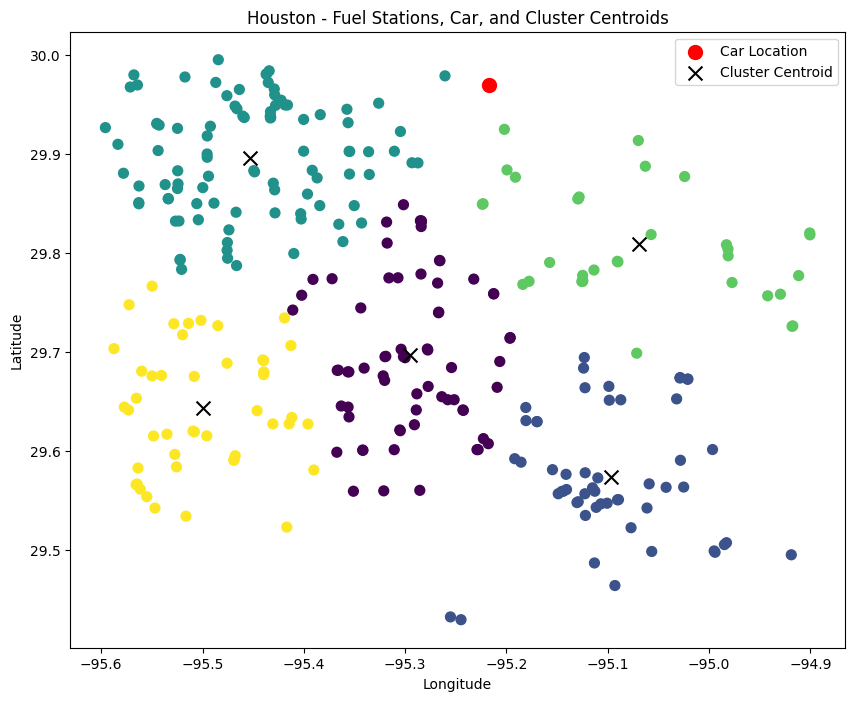

In [6]:
import matplotlib.pyplot as plt

# Add labels and legends for clarity
plt.figure(figsize=(10, 8))  # Resize the plot for better readability

# Plot fuel stations and their clusters (each color point for clusters)
stations_scatter = stations.plot.scatter(x='Lon', y='Lat', c='Cluster', colormap='viridis', s=50, ax=plt.gca(), colorbar=False)  # Removed colorbar

# Plot car location
car_scatter = pd.DataFrame({'Lat': [car_lat], 'Lon': [car_lon]}).plot.scatter(x='Lon', y='Lat', color='red', s=100, ax=stations_scatter, label='Car Location')

# Plot cluster centroids
centroids_scatter = centroids.plot.scatter(x='Lon', y='Lat', color='black', marker='x', s=100, ax=car_scatter, label='Cluster Centroid')

# Add legend and titles
plt.legend()
plt.title('Houston - Fuel Stations, Car, and Cluster Centroids')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [7]:
# compute paths between car and stations
#used for tableau

paths = []
for idx, row in recommendations.iterrows():
    paths.append({'Path_ID': idx, 'Point_Order': 1, 'Lat': car_lat, 'Lon': car_lon, 'Type': 'Car'})  #1 is Car
    paths.append({'Path_ID': idx, 'Point_Order': 2, 'Lat': row['Lat'], 'Lon': row['Lon'], 'Type': 'Station'})  #2 is at station
paths_df = pd.DataFrame(paths)

In [8]:
# #Export to Tableau
# stations['Type'] = 'Station'
# car_df = pd.DataFrame({'Lat': [car_lat], 'Lon': [car_lon], 'Type': 'Car', 'Name': 'Car', 'Fuel_Percentage': [fuel['Fuel_Percentage'].iloc[0]]})
# centroids['Type'] = 'Centroid'
# stations.to_csv('stations.csv', index=False)
# car_df.to_csv('car.csv', index=False)
# centroids.to_csv('centroids.csv', index=False)
# recommendations.to_csv('recommendations.csv', index=False)
# paths_df.to_csv('paths.csv', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d8b65ebd-b2f0-463d-a933-652e7356a3e2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>